Dvice: cpu
Number of total images: 1799
Number of train images: 1499
Number of test images: 300
torch.Size([3, 1088, 1088])


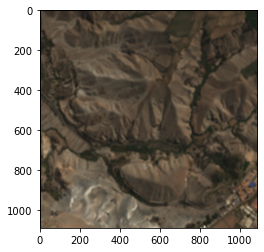

In [30]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torchvision.transforms.functional as TF

from src.datasets import MyDataset
from utils.helper import load_model_dict
from utils.config import WorldStrat_path, DEVICE
from utils.calculate_psnr_ssim import calculate_psnr
from torch.utils.data import DataLoader
from models.network_swinir import SwinIR

dataset = MyDataset(WorldStrat_path)
# split train/test dataset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 300, 300])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

print(f'Dvice: {DEVICE}')
print(f'Number of total images: {len(dataset)}')
print(f'Number of train images: {len(train_dataset)}')
print(f'Number of test images: {len(test_dataset)}')

print(dataset[0][0].shape)
plt.imshow(dataset[10][0].permute(1, 2, 0).numpy())

In [6]:
upscale = 4
window_size = 8
height = (500 // upscale // window_size + 1) * window_size
width = (500 // upscale // window_size + 1) * window_size
model = SwinIR(upscale=8, img_size=(height, width),
                window_size=window_size, img_range=1., depths=[6, 6, 6, 6],
                embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffledirect')

model.to(DEVICE)

load_model_dict(model, 'model_zoo/swinir.pth')

Model path is not exist!


In [3]:
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(epochs, model, dataloader, criterion, optimizer, device, save_path=None):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(dataloader):
            hr, lr = batch
            hr, lr = hr.to(device), lr.to(device)
            optimizer.zero_grad()
            output = model(lr)
            loss = criterion(output, hr)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'epoch: {epoch}, loss: {total_loss / len(dataloader)}')
        if save_path is not None:
            torch.save(model.state_dict(), save_path)

train(100, model, train_loader, criterion, optimizer, DEVICE, save_path='model_zoo/swinir.pth')

100%|██████████| 900/900 [05:29<00:00,  2.74it/s]


epoch: 0, loss: 0.017253234765181938


100%|██████████| 900/900 [05:20<00:00,  2.81it/s]


epoch: 1, loss: 0.012862956120322148


100%|██████████| 900/900 [05:21<00:00,  2.80it/s]


epoch: 2, loss: 0.010882016117684544


100%|██████████| 900/900 [05:19<00:00,  2.82it/s]


epoch: 3, loss: 0.00947505858209398


100%|██████████| 900/900 [05:20<00:00,  2.81it/s]


epoch: 4, loss: 0.009139344502861302


100%|██████████| 900/900 [05:24<00:00,  2.78it/s]


epoch: 5, loss: 0.008280154100050115


100%|██████████| 900/900 [05:19<00:00,  2.81it/s]


epoch: 6, loss: 0.007835156651368986


100%|██████████| 900/900 [05:32<00:00,  2.71it/s]


epoch: 7, loss: 0.0078046227945014835


100%|██████████| 900/900 [05:24<00:00,  2.77it/s]


epoch: 8, loss: 0.00738084897528299


100%|██████████| 900/900 [05:25<00:00,  2.77it/s]


epoch: 9, loss: 0.007039592981907643


100%|██████████| 900/900 [05:26<00:00,  2.76it/s]


epoch: 10, loss: 0.006835227412068182


 23%|██▎       | 203/900 [01:13<04:12,  2.76it/s]


KeyboardInterrupt: 

In [29]:
def calute_average_batch_psnr(hr_batch, sr_batch, max_value=255):
    psnr = []
    for hr, sr in zip(hr_batch, sr_batch):
        hr = hr.permute(1, 2, 0).cpu().numpy()*255
        sr = sr.permute(1, 2, 0).cpu().numpy()*255
        psnr.append(calculate_psnr(hr, sr, crop_border=0))
    return np.mean(psnr)

def evaluate(model, dataloader):
    model.eval()
    psnr = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            hr, lr = batch
            hr = hr.to(DEVICE)
            lr = lr.to(DEVICE)
            res = model(lr)
            psnr.append(calute_average_batch_psnr(hr, res))
    print(f'Average PSNR: {np.mean(psnr)}')
    return

evaluate(model, test_loader)

100%|██████████| 150/150 [03:49<00:00,  1.53s/it]

PSNR: 7.346408968662155


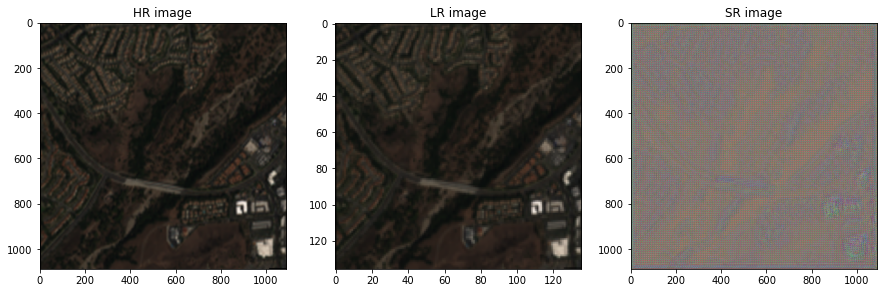

In [28]:
# plot sameple result
def plot_cv_images(hr, lr, res):
    hr, lr, res = hr.astype(np.uint8), lr.astype(np.uint8), res.astype(np.uint8)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(hr)
    ax[0].set_title('HR image')
    ax[1].imshow(lr)
    ax[1].set_title('LR image')
    ax[2].imshow(res)
    ax[2].set_title('SR image')

#  save sample results
def save_sample_result(path_folder, save=True):
    model.eval()
    with torch.no_grad():
        for batch in train_loader:
            hr_batch, lr_batch = batch
            hr_batch = hr_batch.to(DEVICE)
            lr_batch = lr_batch.to(DEVICE)
            res_batch = model(lr_batch)

            hr = cv2.cvtColor(hr_batch[0].permute(1, 2, 0).cpu().numpy(), cv2.COLOR_RGB2BGR) * 255
            lr = cv2.cvtColor(lr_batch[0].permute(1, 2, 0).cpu().numpy(), cv2.COLOR_RGB2BGR) * 255
            res = cv2.cvtColor(res_batch[0].permute(1, 2, 0).cpu().detach().numpy(), cv2.COLOR_RGB2BGR) * 255
            
            plot_cv_images(hr, lr, res)
            cv2.imwrite(os.path.join(path_folder, 'hr.png'), hr)
            cv2.imwrite(os.path.join(path_folder, 'lr.png'), lr)
            cv2.imwrite(os.path.join(path_folder, 'res.png'), res)
    
            break
    
save_sample_result('./results')

In [53]:
img1 = cv2.imread('/Users/terry/Desktop/super-resolution/results/hr.png')
img2 = cv2.imread('/Users/terry/Desktop/super-resolution/results/lr.png')

img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]), interpolation=cv2.INTER_CUBIC)

from utils.calculate_psnr_ssim import calculate_psnr

calculate_psnr(img1, img2, crop_border=5)


38.70530914601709